# Modelling 

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, roc_auc_score
)

import joblib

## loading datasets & further pre-processing

In [96]:
train_df = pd.read_csv(r'..\5. Modelling\train_data.csv', header=0)
test_df = pd.read_csv(r'..\5. Modelling\test_data.csv', header=0)

train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4882 entries, 0 to 4881
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Text    4882 non-null   object 
 1   Target  4882 non-null   float64
dtypes: float64(1), object(1)
memory usage: 76.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1221 entries, 0 to 1220
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Text    1221 non-null   object 
 1   Target  1221 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [97]:
# seperate features and labels
X_train_raw = train_df['Text']
Y_train_raw = train_df['Target']

X_test_raw = test_df['Text']
Y_test_raw = test_df['Target']

In [98]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(Y_train_raw)
y_test = label_encoder.transform(Y_test_raw)

In [99]:
#TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

In [100]:
# Save vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

## Using SVM

In [101]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [102]:
params_grid = [{'kernel':['rbf'], 'gamma':[1e-3,1e-4], 'C':[1,10,100,1000], 'decision_function_shape': ['ovr', 'ovo']},
               {'kernel': ['linear'], "C":[1,10,100,1000],'decision_function_shape': ['ovr', 'ovo']}]

In [103]:
svm_model = GridSearchCV(SVC(probability=True), params_grid, cv = 5)
svm_model.fit( X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'decision_function_shape': ['ovr', 'ovo'],
                          'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000],
                          'decision_function_shape': ['ovr', 'ovo'],
                          'kernel': ['linear']}])

In [104]:
print("Best parameters for SVM:", svm_model.best_params_)
best_svm_model = svm_model.best_estimator_

Best parameters for SVM: {'C': 1, 'decision_function_shape': 'ovr', 'kernel': 'linear'}


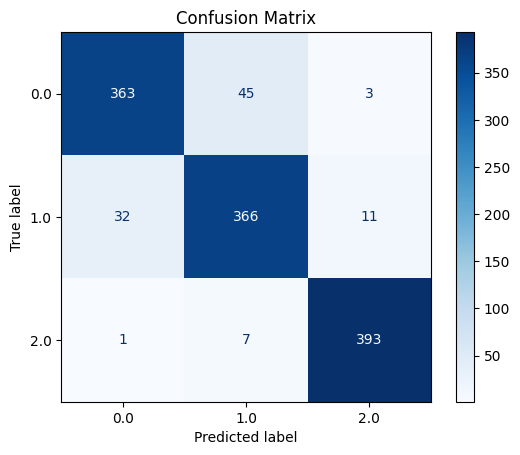

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       411
           1       0.88      0.89      0.89       409
           2       0.97      0.98      0.97       401

    accuracy                           0.92      1221
   macro avg       0.92      0.92      0.92      1221
weighted avg       0.92      0.92      0.92      1221



Accuracy:  0.9189
Precision: 0.9190
Recall:    0.9189
F1 Score:  0.9188


In [105]:
y_pred_svm = svm_model.predict(X_test)

#confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

#classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm, average='weighted')
recall = recall_score(y_test, y_pred_svm, average='weighted')
f1 = f1_score(y_test, y_pred_svm, average='weighted')
print(f"\n\nAccuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


In [106]:

y_score_svm = best_svm_model.predict_proba(X_test)

auc_score = roc_auc_score(y_test, y_score_svm, multi_class='ovr', average='macro')

print(f"AUC-ROC Score (macro-average): {auc_score:.4f}")

AUC-ROC Score (macro-average): 0.9806


In [107]:
#save the model
joblib.dump(svm_model, 'svm_model.pkl')


['svm_model.pkl']

## Using Random Forest

In [108]:
from sklearn.ensemble import RandomForestClassifier

In [109]:
# hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}


In [110]:
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    return_train_score=True,
    n_jobs=-1,
    verbose=2 
)

In [111]:
# fit the model to the training set
grid_search.fit(X_train, y_train)

# check the best model
best_rf = grid_search.best_estimator_
print("Best Parameters:\n", grid_search.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best Parameters:
 {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}



Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       411
           1       0.91      0.82      0.87       409
           2       0.97      0.98      0.98       401

    accuracy                           0.91      1221
   macro avg       0.91      0.91      0.91      1221
weighted avg       0.91      0.91      0.91      1221



Accuracy:  0.9115479115479116
Precision:  0.9132570593514487
Recall:  0.9115479115479116
F1 Score:  0.9110433348980554


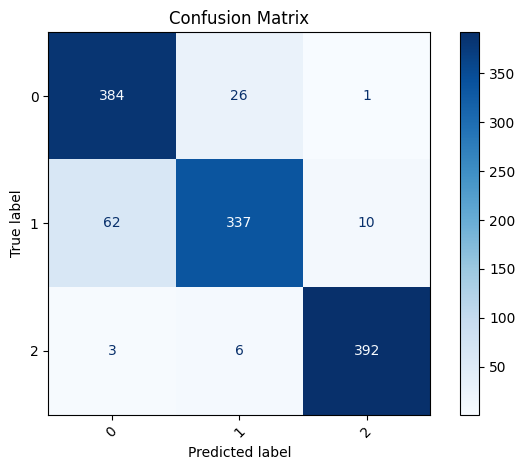

In [112]:
# Predict on test set
y_pred_rf = best_rf.predict(X_test)

# Evaluate
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

print(f"\n\nAccuracy: ", accuracy_score(y_test, y_pred_rf))
print(f"Precision: ", precision_score(y_test, y_pred_rf, average='weighted'))
print(f"Recall: ", recall_score(y_test, y_pred_rf, average='weighted') )
print(f"F1 Score: ",  f1_score(y_test, y_pred_rf, average='weighted'))
 
# 7. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [113]:
joblib.dump(best_rf, 'rf_model.pkl')


['rf_model.pkl']

## Multinomial Naive Bayes

In [114]:
from sklearn.naive_bayes import MultinomialNB

In [115]:
# Define the hyperparameter grid
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]  # try various smoothing values
}

In [116]:
# Set up GridSearchCV
nb_grid = GridSearchCV(MultinomialNB(), 
                       param_grid, 
                       cv=3, 
                       scoring='accuracy', 
                       n_jobs=-1, 
                       verbose=2)
# 3. Fit the model
nb_grid.fit(X_train, y_train)

print("Best hyperparameters for MultinomialNB:", nb_grid.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best hyperparameters for MultinomialNB: {'alpha': 0.1}


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       411
           1       0.82      0.92      0.86       409
           2       0.96      0.96      0.96       401

    accuracy                           0.90      1221
   macro avg       0.91      0.90      0.90      1221
weighted avg       0.91      0.90      0.90      1221



Accuracy:  0.9000819000819
Precision:  0.905267880006645
Recall:  0.9000819000819
F1 Score:  0.9003932256277264


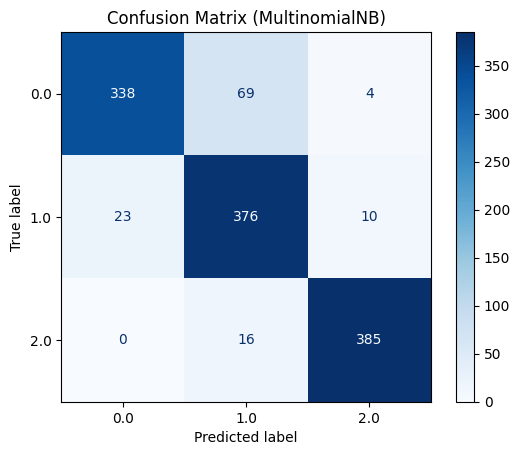

In [117]:
# Predict on test data
best_nb = nb_grid.best_estimator_
y_pred_nb = best_nb.predict(X_test)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_nb))
print(f"\n\nAccuracy: ", accuracy_score(y_test, y_pred_nb))
print(f"Precision: ", precision_score(y_test, y_pred_nb, average='weighted'))
print(f"Recall: ", recall_score(y_test, y_pred_nb, average='weighted') )
print(f"F1 Score: ",  f1_score(y_test, y_pred_nb, average='weighted'))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (MultinomialNB)")
plt.show()


In [118]:
joblib.dump(best_nb, 'nb_model.pkl')

['nb_model.pkl']

## Logistic regression

In [119]:

from sklearn.linear_model import LogisticRegression

In [120]:
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],             
    'solver': ['lbfgs'],           # 'lbfgs' handles multiclass well
    'max_iter': [500]
}

In [121]:
# Initialize GridSearchCV
logreg_grid = GridSearchCV(LogisticRegression(multi_class='ovr'), 
                           param_grid, 
                           cv=3, 
                           n_jobs=-1,
                           verbose=2)

# Fit model
logreg_grid.fit(X_train, y_train)

print("Best parameters:", logreg_grid.best_params_)

best_logreg = logreg_grid.best_estimator_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters: {'C': 10, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}



Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       411
           1       0.89      0.87      0.88       409
           2       0.97      0.98      0.98       401

    accuracy                           0.92      1221
   macro avg       0.92      0.92      0.92      1221
weighted avg       0.92      0.92      0.92      1221


Accuracy:  0.9164619164619164
Precision:  0.9163009516682272
Recall:  0.9164619164619164
F1 Score:  0.9163562973807484


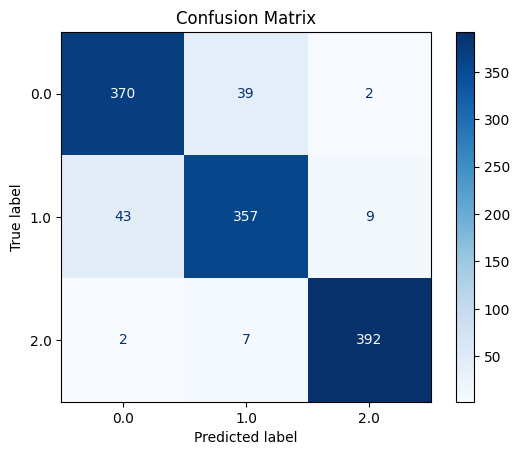

In [122]:
# Predict
y_pred_logreg = best_logreg.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred_logreg)
precision = precision_score(y_test, y_pred_logreg, average='weighted')
recall = recall_score(y_test, y_pred_logreg, average='weighted')
f1 = f1_score(y_test, y_pred_logreg, average='weighted')

#confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg))
print(f"\nAccuracy: ", accuracy_score(y_test, y_pred_logreg))
print(f"Precision: ", precision_score(y_test, y_pred_logreg, average='weighted'))
print(f"Recall: ", recall_score(y_test, y_pred_logreg, average='weighted') )
print(f"F1 Score: ",  f1_score(y_test, y_pred_logreg, average='weighted'))

#confusion matric
cm = confusion_matrix(y_test, y_pred_logreg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [123]:
# AUCROC
y_score_LR = best_logreg.predict_proba(X_test)

auc_score = roc_auc_score(y_test, y_score_LR, multi_class='ovr', average='macro')

print(f"AUC-ROC Score (macro-average): {auc_score:.4f}")

AUC-ROC Score (macro-average): 0.9802


In [124]:
joblib.dump(best_logreg, 'logreg_model.pkl')

['logreg_model.pkl']

In [125]:
#sample try
# 1. Input new raw text
new_text = ["I love eating fried chicken"]

# 2. Vectorize the text using your trained vectorizer
new_text_vectorized = vectorizer.transform(new_text)

# 3. Predict the class
predicted_class = best_logreg.predict(new_text_vectorized)

# 4. Decode the numeric label back to original class name
decoded_class = label_encoder.inverse_transform(predicted_class)

print("Predicted class:", decoded_class[0])

Predicted class: 0.0
